In [1]:
%gui qt

In [1]:
import napari
import sys
Linux = True
if Linux:
    sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
else:
    sys.path.insert(0,'C:\\Users\\gh464\\Documents\\GitHub\\SYMPTOMM2\\')
from SYMPTOMM.cell import Cell
from SYMPTOMM.scene_functions import create_space, step_and_update
from SYMPTOMM.trench_geometry import trench_creator
from SYMPTOMM.phase_contrast_drawing import *
import tifffile
import numpy as np
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.exposure import rescale_intensity
from ipywidgets import interactive
import os
from PIL import Image
import skimage
from tqdm.notebook import tqdm
import gc
from SYMPTOMM.PSF import get_phase_contrast_kernel, get_condensers
#viewer = napari.view_image(real_image)


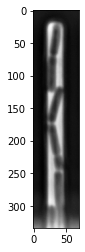

In [2]:
real_image = tifffile.imread("/home/georgeos/Insync/gh464@cam.ac.uk/Google Drive - Shared with me/Project_N--SyntheticMicrographs_MM/Movies/B_subtilis_Phase_Example_20181113.tif")
real_image = real_image[10][:-20,60:130][::-1]
plt.imshow(real_image,cmap="Greys_r")

In [3]:
real_image[:,19:-24].shape

(334, 27)

### Scope props

In [5]:
condensers = get_condensers()
W, R, diameter = condensers["Ph3"]
radius=50
#F = 5
λ = 0.6
resize_amount = 3
pix_mic_conv = 0.0655 #DeLTA paper reports 2x2 binning 
scale = pix_mic_conv / resize_amount 
min_sigma = 0.42*0.6/6 / scale # micron#
sigma=15
NA=1.45
n = 1.4
kernel_params = (R,W,radius,scale,NA,n,sigma,λ)
temp_kernel = get_phase_contrast_kernel(*kernel_params)

/home/georgeos/Documents/GitHub/SYMPTOMM2/SYMPTOMM/PSF.py:105: RuntimeWarning: invalid value encountered in true_divide
  kernel1 = 2*jv(1,rr)/(rr)
/home/georgeos/Documents/GitHub/SYMPTOMM2/SYMPTOMM/PSF.py:108: RuntimeWarning: invalid value encountered in true_divide
  kernel2 = 2*(R-W)**2/R**2 * jv(1,(R-W)**2/R**2 * rr)/rr


### Do long cells

In [6]:
sim_length = 4
cell_timeseries, space = run_simulation(
    trench_length=20.5, 
    trench_width=1.65, 
    cell_max_length=5.5, 
    cell_width= 0.9,
    sim_length = sim_length,
    pix_mic_conv = pix_mic_conv,
    gravity=0.0009,
    phys_iters=500,
    max_length_var = 3,
    width_var = 0.031,
    save_dir="/home/georgeos"
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = False
offset = 30
mask_threshold = 12
label_masks = False
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=16)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Timeseries Properties:   0%|          | 0/4 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
media_multiplier=30
cell_multiplier=1
device_multiplier=-50
y_border_expansion_coefficient = 3
x_border_expansion_coefficient = 3



temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
   main_segments=main_segments,
    offset=offset,
    scene = scenes[0][0],
    mask = scenes[0][1],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=cell_multiplier,
    y_border_expansion_coefficient = y_border_expansion_coefficient,
    x_border_expansion_coefficient = x_border_expansion_coefficient,
    fluorescence=False,
    defocus=0
)



### Generate temporary image to make same shape
convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

In [8]:
viewer = napari.view_image(real_resize)
media_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "media")
cell_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "cell")
device_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "device")

/home/georgeos/anaconda3/envs/SYMPTOMM/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [9]:
real_media_mean = real_resize[np.where(media_label.data)].mean();
real_cell_mean = real_resize[np.where(cell_label.data)].mean(); 
real_device_mean = real_resize[np.where(device_label.data)].mean()
real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))

real_media_var = real_resize[np.where(media_label.data)].var();
real_cell_var = real_resize[np.where(cell_label.data)].var(); 
real_device_var = real_resize[np.where(device_label.data)].var()
real_vars = np.array((real_media_var, real_cell_var, real_device_var))

image_params = (real_media_mean, real_cell_mean, real_device_mean, real_means, real_media_var, real_cell_var, real_device_var, real_vars)

<ipython-input-9-c6a8b6c5825e>:1: RuntimeWarning: Mean of empty slice.
  real_media_mean = real_resize[np.where(media_label.data)].mean();
/home/georgeos/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-9-c6a8b6c5825e>:2: RuntimeWarning: Mean of empty slice.
  real_cell_mean = real_resize[np.where(cell_label.data)].mean();
<ipython-input-9-c6a8b6c5825e>:3: RuntimeWarning: Mean of empty slice.
  real_device_mean = real_resize[np.where(device_label.data)].mean()
<ipython-input-9-c6a8b6c5825e>:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  real_media_var = real_resize[np.where(media_label.data)].var();
/home/georgeos/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/georgeos/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: in

In [10]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,len(scenes)-1,1),
    noise_var=(0,0.01, 0.0001),
    scale=fixed(scale),
    match_fourier = [True, False],
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient),
    fluorescence=[False,True],
    defocus = (0,50,1/50)
);

In [11]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [32]:
generate_training_data(interactive_output = params, sample_amount = 0.0, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  1, save_dir = "/home/georgeos/Insync/gh464@cam.ac.uk/Google Drive - Shared with me/Project_N--SyntheticMicrographs_MM/Movies/syn_images/")

Sample generation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


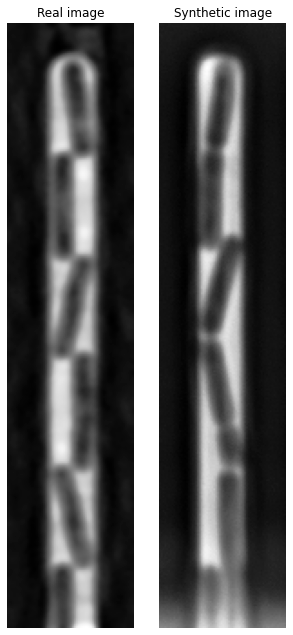

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(5,15))
ax1.imshow(gaussian_filter(tifffile.imread("/home/georgeos/Insync/gh464@cam.ac.uk/Google Drive - Shared with me/Project_N--SyntheticMicrographs_MM/Movies/syn_images/convolutions/synth_00001.tif"),1),cmap="Greys_r")
ax2.imshow(real_resize,cmap="Greys_r")
for ax in (ax1, ax2):
    ax.axis("off")
ax1.set_title("Real image")
ax2.set_title("Synthetic image")
plt.savefig("/home/georgeos/Insync/gh464@cam.ac.uk/Google Drive - Shared with me/Project_N--SyntheticMicrographs_MM/Movies/comparisons/bacillus_syn_vs_real_{}.pdf")